In [3]:
#import dependencies
import keras
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D, SimpleRNN
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#set hyperparameters
output_dir = 'model_output/rnn'

#training
epochs = 16
batch_size = 128

#vector-space embedding
n_dim = 64
n_unique_words = 10000
max_review_length = 100 #lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2

#rnn layer architecture
n_rnn = 256 
drop_rnn = 0.2

In [5]:
#model architecture
model = Sequential()

#vector-space embedding:
model.add(Embedding(n_unique_words, n_dim,
                    input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

#rnn layer:
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))

#output layer
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 64)          0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               82176     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


In [7]:
#data preprocessing
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)
#standardizing input length by padding and truncating
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
#Create an object and directory for checkpoint model parameters after each epoch
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/RNNweights.{epoch:02d}.hdf5")

if not os.path.exists((output_dir)):
    os.makedirs(output_dir)

In [10]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=[modelcheckpoint])

Epoch 1/16
196/196 [==============================] - 19s 91ms/step - loss: 0.6852 - accuracy: 0.5435 - val_loss: 0.6518 - val_accuracy: 0.5950
Epoch 2/16
196/196 [==============================] - 19s 97ms/step - loss: 0.6461 - accuracy: 0.6118 - val_loss: 0.6373 - val_accuracy: 0.6168
Epoch 3/16
196/196 [==============================] - 19s 98ms/step - loss: 0.5397 - accuracy: 0.7215 - val_loss: 0.6458 - val_accuracy: 0.6010
Epoch 4/16
196/196 [==============================] - 20s 102ms/step - loss: 0.4800 - accuracy: 0.7675 - val_loss: 0.5805 - val_accuracy: 0.6969
Epoch 5/16
196/196 [==============================] - 21s 106ms/step - loss: 0.6409 - accuracy: 0.6595 - val_loss: 0.6470 - val_accuracy: 0.6293
Epoch 6/16
196/196 [==============================] - 21s 105ms/step - loss: 0.5703 - accuracy: 0.7010 - val_loss: 0.5072 - val_accuracy: 0.7521
Epoch 7/16
196/196 [==============================] - 21s 105ms/step - loss: 0.5749 - accuracy: 0.7220 - val_loss: 0.6218 - val_accur

In [11]:
model.load_weights(output_dir+"/RNNweights.09.hdf5")

In [12]:
y_hat = model.predict_on_batch(x_valid)

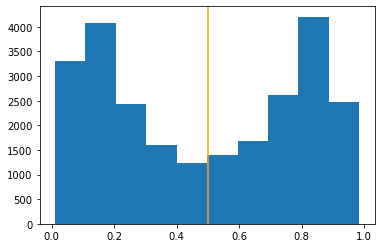

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
pct_auc = roc_auc_score(y_valid, y_hat) * 100
"{:0.2f}".format(pct_auc)

'82.48'